In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv(override=True)

from pydantic import BaseModel, Field

import nest_asyncio
nest_asyncio.apply()
from llama_index.core.vector_stores.types import MetadataFilters, MetadataFilter, FilterOperator, FilterCondition
from llama_index.core.prompts import PromptTemplate
from llama_index.core.output_parsers.pydantic import PydanticOutputParser
from llama_index.core.schema import TextNode, IndexNode, NodeRelationship, RelatedNodeInfo
from typing import List, Dict
import re
import plotreader
from plotreader.utils.document import ScientificPaperHandler
from plotreader.utils.base import BasicAnthropicLLM

In [3]:
handler = ScientificPaperHandler(
    filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/nihms-1538039.pdf",
    document_id = "3de6841c-fba6-4124-a28a-2c53124202af",
    # filepath="/Users/loyalshababo/dev/plotreader/sandbox/storage/tmp/s42003-021-01878-9.pdf",
    # document_id = "b562c2f2-b776-4829-b18c-6c6ebf4f788d",
    name="nihms-1538039",
    desc="A scientific paper",
    storage_dir = "./storage",
    use_cache = False
)

In [4]:
all_nodes = handler.load_docs()

In [7]:
all_nodes

[TextNode(id_='2489352a-7c62-4272-8a19-0746ceb0f845', embedding=None, metadata={'Header_1': 'Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics', 'experimental_variable_entities': ['channelrhodopsin', 'optogenetics'], 'fig_refs': []}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='c2155598-52f8-4e4f-9b94-62149747c0b0', node_type=None, metadata={}, hash=None)}, text='Machine learning-guided channelrhodopsin engineering enables minimally-invasive optogenetics\n\nClaire N. Bedbrook<sup>1</sup>, Kevin K. Yang<sup>2,†</sup>, J. Elliott Robinson<sup>1,†</sup>, Elisha D. Mackey<sup>1</sup>, Viviana Gradinaru<sup>1,*</sup>, Frances H. Arnold<sup>1,2,*<

In [5]:
fig_num = 3

filters = MetadataFilters(filters=[
    MetadataFilter(
        key="fig_refs", 
        value=f'Figure {fig_num}',
        operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2d',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    # ),
    # MetadataFilter(
    #     key="fig_refs", 
    #     value='Figure 2e',
    #     operator=FilterOperator.TEXT_MATCH_LIST
    )],
    condition=FilterCondition.OR
)

query_tool = handler.query_engine_tool(top_k=10, metadata_filters=filters)

In [6]:
class Variable(BaseModel):
    name: str
    categorical: bool

class Experiment(BaseModel):
    independent_variables: list[Variable]
    dependent_variables: list[Variable]

class Plot(BaseModel):
    name: str
    experiments: list[Experiment]

class Panel(BaseModel):
    name: str
    plots: list[Plot]

class Figure(BaseModel):
    name: str
    panels: list[Panel]
    # statistics: List[str]



In [7]:
output_parser = PydanticOutputParser(output_cls=Figure)

prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting data from figures in scientific papers.
    You will always primarily look to the image of the figure.
    You will look to text to obtain more detail if necessary.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
Complete the following task by visual inspection of the figure ONLY. Omit information if not available in the image.
For each plot in each panel of THE IMAGE of Fig. {fig_num}, determine the experiment in terms of Independent variables (IVs) and dependent variable (DV). 
By plot, we mean each set of axes or displays. Each panel can have multiple plots. See the json definition below for more.

Return your answer as structured data.
"""

prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

In [8]:
response = query_tool(prompt)

In [9]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [10]:
figure_struct = output_parser.parse(response.content)

In [11]:
fig_description = f"{figure_struct.name}"

for panel in figure_struct.panels:
    fig_description += f"\n\tPanel: {panel.name}\n"
    for plot in panel.plots:
        fig_description += f"\n\t\tPlot: {plot.name}"
        for experiment in plot.experiments:
            fig_description += f"\n\t\t\t{experiment}"

print(fig_description)

Figure 3
	Panel: b

		Plot: Microscope images
			independent_variables=[Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Neuron morphology', categorical=False)]
	Panel: c

		Plot: Photocurrent bar graphs
			independent_variables=[Variable(name='ChR variant', categorical=True), Variable(name='Light intensity', categorical=True)] dependent_variables=[Variable(name='Photocurrent', categorical=False)]
	Panel: d

		Plot: Spike fidelity vs Light intensity
			independent_variables=[Variable(name='Light intensity', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: e

		Plot: Spike fidelity vs Frequency
			independent_variables=[Variable(name='Frequency', categorical=False), Variable(name='ChR variant', categorical=True)] dependent_variables=[Variable(name='Spike fidelity', categorical=False)]
	Panel: f

		Plot: Voltage traces
			independent_variables=[Variable(n

In [12]:
panel = figure_struct.panels[2]
plot = panel.plots[0]
exp = plot.experiments[0]

class CategoricalVariable(BaseModel):
    name: str
    label_type: str = Field(
        ...,
        description="What type of visual signifier is used to label this class in the plot (e.g. color, markertype, etc.)"
    )
    values: dict[str, str] = Field(
        ...,
        description="A map from Category > Label that can act as a legend for this variable."
    )

class NumericVariable(BaseModel):
    name: str
    values: list[float]
    unit: str

plot_struct_str = f"Plot: {plot.name}"
for experiment in plot.experiments:
    plot_struct_str += f"\n\t{experiment}"

ivs_with_values = []

for iv in exp.independent_variables:

    print(iv)
    if iv.categorical:

        var_cls = CategoricalVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting categorical labels from plots in scientific papers.
    You will always primarily look to the image of the figure.
    If the information is not available in the image, you can look to the text.
    You will always dummy check your answer by counting the number of expected labels in the image.
    When there is a discrepency between text and graphic, always defer to the graphic.

YOUR CURRENT TASK:
        In Figure {fig_num}{panel.name}, plot title: {plot.name}, what values are taken by the independent variable {iv.name}?
    Return your answer as structured data.
        """
        
    else:
        var_cls = NumericVariable
        prompt = f"""
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given an numeric independent variable and a plot containing datapoints corresponding to that variable.
    Your job is to give the set of values for that variable for the markers in the the specific plot (not the whole figure). 
    You will always dummy check your answer by counting the number of expected datapoints in the plot.

    YOUR CURRENT TASK:

In Figure {fig_num}{panel.name}, plot title/description: {plot.name}, what set are the values of {iv.name} plotted across all data in the panel?
    IMPORTANT: 
        WE WANT TO MATCH THE FIGURE. USE THE TEXT TO HELP, BUT IF THERE IS A DISCREPANCY, RESOLVE ASSUMING THE IMAGE IS CORRECT.
        COUNT THE NUMBER OF POINTS OR LINES IN THE IMAGE TO ENSURE THAT YOU RETURN THE CORRECT NUMBER OF VALUES.
        THAT IS, DO NOT REPORT THE LOCATIONS OF AXIS TICKE MARKS OR TICK MARK LABELS, REPORT THE VALUES OF THE POINTS ON THE PLOT!!!
    Return your answer as structured data.
        """

    # prompt = f"""In Figure 2, what categories are shown for the independent variable: {exp.independent_variables[1].name}?

    # What categories are shown in this plot for the independent variable: {exp.independent_variables[1].name}?

    # {our_info}
    # """

    output_parser = PydanticOutputParser(output_cls=var_cls)
    prompt = PromptTemplate(prompt, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    # response = query_tool(prompt)
    # text = response.content

    response = query_tool(prompt)
    text = response.content

    ivs_with_values.append(output_parser.parse(text))
# print(var_struct)


name='Light intensity' categorical=False
name='ChR variant' categorical=True


In [13]:
ivs_with_values

[NumericVariable(name='Light intensity', values=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0], unit='mW mm^-2'),
 CategoricalVariable(name='ChR variant', label_type='color', values={'ChRger1': 'pink', 'ChRger2': 'blue', 'ChRger3': 'green', 'CoChR': 'gray', 'ChR2': 'black'})]

In [14]:
response.raw_output.source_nodes

[NodeWithScore(node=TextNode(id_='7ff45e61-0239-4cd0-9902-00f4f80a99df', embedding=None, metadata={'Header_1': 'Online methods', 'Header_2': 'References', 'Header_3': 'Figure 3. ChRger variants in cultured neurons and in acute brain slices outperform the commonly used ChR2(H134R) and the high performance CoChR. (continued)', 'experimental_variable_entities': ['ChRger variants', 'ChR2(H134R)', 'CoChR', 'light irradiances', 'rAAV-PHP.eB', 'hSyn-ChRger2', 'hSyn-ChR2(H134R)', 'fraction of light excitable neurons', 'photocurrent strength', 'spike fidelity', 'stimulation frequency', 'viral genomes'], 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='a71f2164-f8f5-48e0-be2c-3f5484fb2c5d', node_type=<ObjectType.TEXT: '1'>, metadata={}, hash='7b659f8233a33154253211184f42d7c03aed827bbfd9936ed9ad29dfd80859c4'), <NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='6d1ee3b6-ef3e-45ae

In [15]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [16]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You are an expert at extracting the values of data points from plots in scientific papers.
    You will be given a numeric dedependent variable and a plot containing data points which have values for that variable.
    Your job is to give values for the markers in the plot as a function of the provided independent variables.
    We want to match the data points in the plot EXACTLY - not just the shapes or trends.
    You will always dummy check your answer by counting the number of expected datapoints, lines, etc in the plot.
    When there is a discrepency between text and graphic, align your answer to the graphic.

In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?
Get the value for each condition. To help, here is our current belief on the independent variables and their values for this plot:
{ind_vars}

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response = query_tool(prompt)
panel_df = output_parser.parse(data_response.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


In [17]:
data_response.raw_output.source_nodes

[NodeWithScore(node=ImageNode(id_='ddbd3ffb-d1c1-4a05-9c3a-180685f3910b', embedding=None, metadata={'page_number': 24, 'fig_refs': ['Figure 3']}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.PARENT: '4'>: RelatedNodeInfo(node_id='79966a73-edea-46f3-b47f-81295e5616cb', node_type=None, metadata={}, hash=None)}, text='The graphic compares the performance of ChRger variants with commonly used ChR2 (H134R) and CoChR in cultured neurons and acute brain slices. It includes data on photocurrent strength, spike fidelity, and light intensity response.\n\na) ChRs were cloned into an AAV vector with either the hSyn or CamKIIa promoter and packaged into rAAV-PHP.eB for expression in culture and in vivo.\n\nb) Cultured neurons expressing ChRgers and ChR2 (H134R) under the hSyn promoter. Images show neurons with ChR2, ChRger1, ChRger2, and ChRger3. Scale bars are 10 μm.\n\nc) Peak and steady-state photocurrent with low-intensity (8x10^-3 mW mm^-2) a

In [18]:
chr_variant_iv = [iv for iv in ivs_with_values if iv.name == 'ChR variant'][0]
# chr_variant_names = [v for v in chr_variant_iv.values]
chr_variant_colors = [v for k,v in chr_variant_iv.values.items()]

# def get_color(color_name):
#     try:
#         return mcolors.to_rgba(color_name)
#     except ValueError:
#         # If the color name is not recognized, you can provide a fallback
#         return mcolors.to_rgba('gray')
    



In [19]:
import seaborn as sns

[]

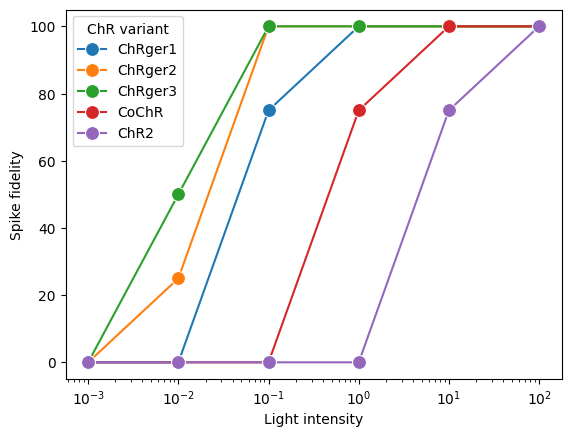

In [20]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [327]:
from PIL import Image

# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img = Image.open('plot.png')

In [328]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO

from plotreader.utils.base import BasicAnthropicLLM

claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")

for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response = claude_mm.message(prompt, images = [source_figure, generated_img])

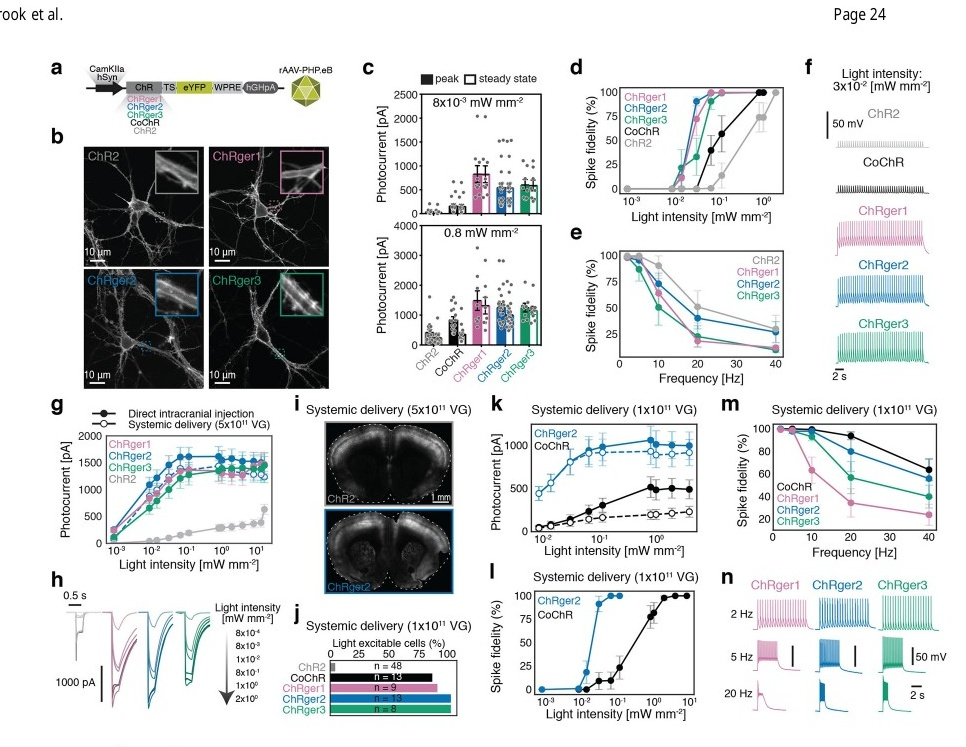

In [329]:
source_figure

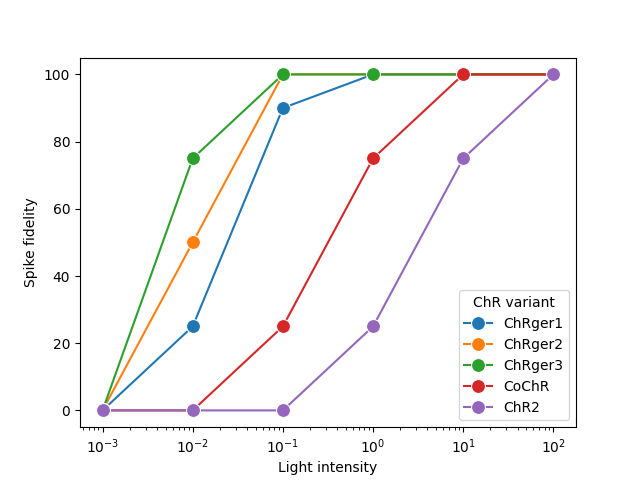

In [330]:
generated_img

In [331]:
print(response.content[0].text)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1, ChRger2, and ChRger3: In the source figure, these curves appear to be smoother and more sigmoidal, especially between 0.01 and 0.1 mW/mm². In the re-plotted data, these curves are more angular and abrupt. For example, ChRger3 in the re-plot jumps from 75% to 100% spike fidelity between 0.01 and 0.1 mW/mm², while in the original, it appears to have a more gradual increase.

2. CoChR performance at low light intensities: In the source figure, CoChR shows some activity (around 25% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm² and only starts showing activity (25%) at 0.1 mW/mm².

3. ChR2 performance at higher light intensities: In the source figure, ChR2 appears to reach close to 100% spike fidelity at 100 mW/mm². In the re-plotted data, ChR2 reaches exactly 100% at this intensity

In [332]:
feedback = response.content[0].text

In [351]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

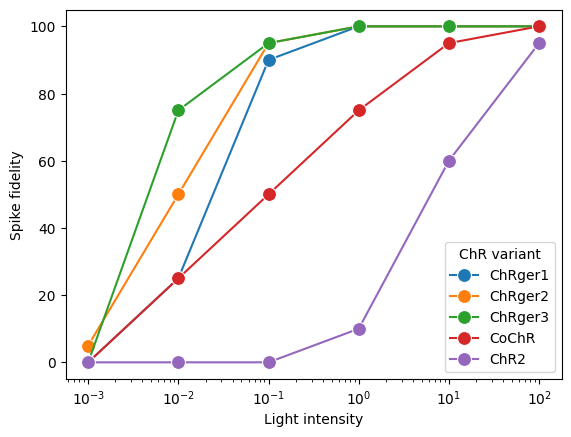

In [352]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [345]:
# get plot as PIL Image
fig = axes.get_figure()
fig.savefig('plot.png')
generated_img_rev = Image.open('plot.png')

In [346]:


claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
You will be given the extracted data as a table.
You will also be given the source figure and a recreation of the plot using our extracted data.
List the three most important differences between the re-plotted data and the data in the source figure.
Be specific and refer to specific quantities and values.

DataFrame:
{panel_df.to_markdown()}
"""


response_2 = claude_mm.message(prompt, images = [source_figure, generated_img_rev])

In [347]:
feedback_2 = response_2.content[0].text
print(feedback_2)

After comparing the re-plotted data with the source figure (Figure 3d), here are the three most important differences:

1. Curve shape for ChRger1: In the source figure, the ChRger1 curve (pink) shows a more gradual increase in spike fidelity between 0.01 and 0.1 mW/mm². However, in the re-plotted data, there's a sharp jump from 25% at 0.01 mW/mm² to 95% at 0.1 mW/mm². This difference significantly alters the shape of the curve for ChRger1 in the low light intensity range.

2. CoChR performance at low intensities: In the source figure, the CoChR curve (black) shows some activity (around 20-30% spike fidelity) at 0.01 mW/mm². However, in the re-plotted data, CoChR shows 0% spike fidelity at 0.01 mW/mm². This difference affects the interpretation of CoChR's sensitivity at low light intensities.

3. ChR2 curve shift: In the source figure, the ChR2 curve (gray) begins to rise noticeably around 1 mW/mm² and reaches about 50% spike fidelity at 10 mW/mm². In the re-plotted data, the ChR2 curv

In [364]:
panel_df

Light intensity ChR variant Spike fidelity
0             0.001     ChRger1              0
1             0.010     ChRger1              0
2             0.100     ChRger1             75
3             1.000     ChRger1            100
4            10.000     ChRger1            100
5           100.000     ChRger1            100
6             0.001     ChRger2              0
7             0.010     ChRger2             25
8             0.100     ChRger2            100
9             1.000     ChRger2            100
10           10.000     ChRger2            100
11          100.000     ChRger2            100
12            0.001     ChRger3              0
13            0.010     ChRger3             50
14            0.100     ChRger3            100
15            1.000     ChRger3            100
16           10.000     ChRger3            100
17          100.000     ChRger3            100
18            0.001       CoChR              0
19            0.010       CoChR              0
20            0.100       CoChR              0
21            1.000       CoChR             50
22           10.000       CoChR            100
23          100.000       CoChR            100
24            0.001        ChR2              0
25            0.010        ChR2              0
26            0.100        ChR2              0
27            1.000        ChR2              0
28           10.000        ChR2             75
29          100.000        ChR2            100

In [348]:
output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


columns = {iv.name: pd.Series() for iv in exp.independent_variables}
dep_var = exp.dependent_variables[0]
columns.update({dep_var.name: pd.Series()})
df = pd.DataFrame(columns)

prompt_base = """
YOUR OVERALL JOB:
    You were previously given the following task:

        In Figure 2{panel_name}, plot {plot_name}, what are the values for the dependent variable {dep_var_name}?

    Here is your previous response:
    {df_table}

    We have reviewed your response and notice these important differences from the source figure:
    {feedback}

    Please revise your response by incorporating and inspecting the source figure.

Return your data using the following column schema: {schema}.
""".format(
    panel_name = panel.name, 
    # dep_var_stat = dep_var.statistics[0],
    plot_name = plot.name,
    dep_var_name = dep_var.name,
    ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
    schema = ", ".join(df.columns),
    feedback = feedback_2,
    df_table = panel_df.to_markdown(),
).replace("{","<").replace("}",">")

prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

data_response_revised = query_tool(prompt)
panel_df = output_parser.parse(data_response_revised.content).to_df(existing_df=df)

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


[]

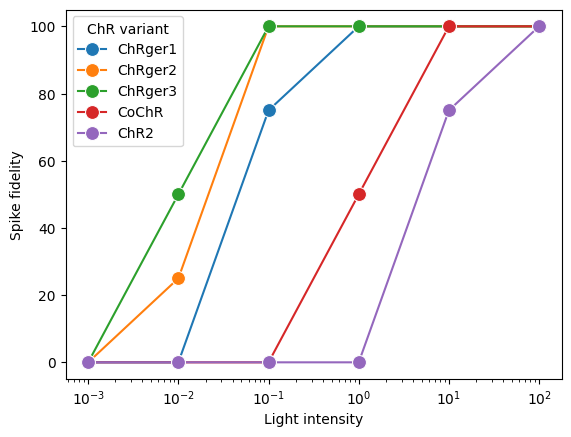

In [28]:


axes = sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
)
axes.semilogx()
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [24]:
from llama_index.core.schema import ImageNode
import requests
from io import BytesIO
from PIL import Image


In [25]:
for node in data_response.raw_output.source_nodes:
    if isinstance(node.node, ImageNode):
        response = requests.get(node.node.image_url)
        source_figure = Image.open(BytesIO(response.content))

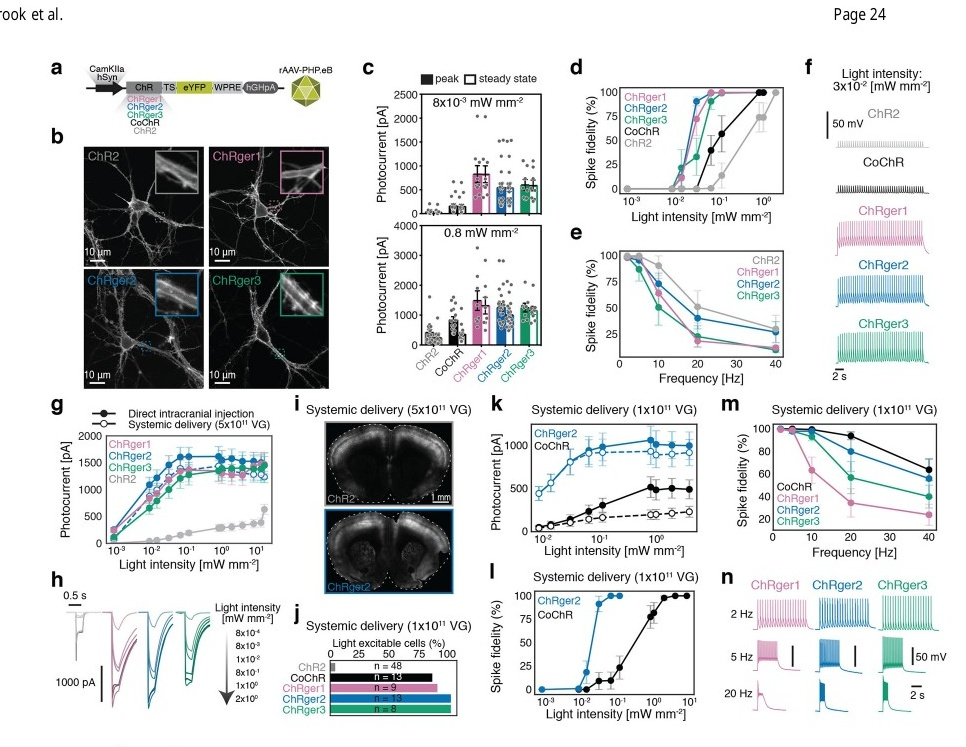

In [26]:
source_figure

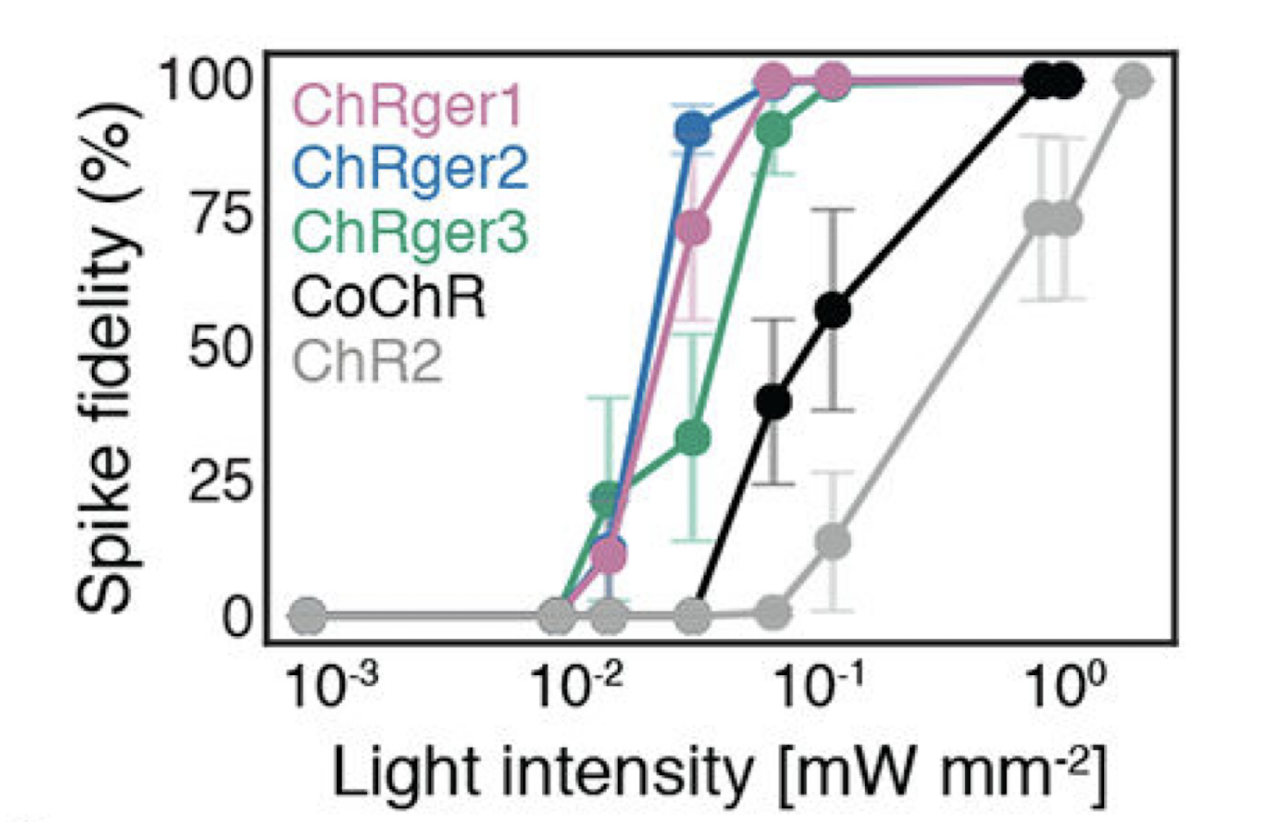

In [27]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
source_image = Image.open(source_panel)
source_image

Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Spike fidelity values for ChRger1 at Light intensity 0.01 from 0 to approximately 10-15. This will fix the relative ordering, as ChRger1 should show some activity at this intensity.

2. Modify the Spike fidelity values for ChRger2 at Light intensity 0.01 from 25 to approximately 15-20. This will better match the curve shown in the original figure.

3. Change the Spike fidelity values for ChRger3 at Light intensity 0.01 from 50 to approximately 20-25. This adjustment will better align with the original figure's curve.

4. Adjust the Spike fidelity values for CoChR at Light intensity 0.1 from 0 to approximately 40-45. This will correct the curve shape for CoChR.

5. Add more data points between Light intensity values of 0.01 and 0.1 for all ChR variants. This will help capture the steeper parts of the curves more accurately, especially for ChRger1, ChRger

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger variants: In the original figure, ChRger2 reaches 100% spike fidelity at a lower light intensity than ChRger1 and ChRger3. Modify the data for ChRger2 to have higher spike fidelity values at lower light intensities.

2. Extend the light intensity range: The original figure shows data points up to 1 mW mm^-2, while the extracted data goes up to 100 mW mm^-2. Remove data points for light intensities above 1 mW mm^-2 for all variants.

3. Add more data points for CoChR: The original figure shows more data points for CoChR between 0.01 and 0.1 mW mm^-2. Add intermediate light intensity values and corresponding spike fidelity values for CoChR in this range.

4. Adjust ChR2 values: The spike fidelity values for ChR2 in the extracted data are too high. Lower the spike fidelity values for ChR2 across all light intensities to better m

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger3: ChRger3 should have higher spike fidelity than ChRger1 at lower light intensities (around 0.01-0.03 mW mm^-2). Decrease the spike fidelity values for ChRger1 and/or increase them for ChRger3 in this range.

2. Extend the range of light intensity for ChR2: Add data points for ChR2 at higher light intensities (3 mW mm^-2 and 10 mW mm^-2). The spike fidelity for ChR2 should reach around 75-80% at 10 mW mm^-2.

3. Adjust the maximum spike fidelity for CoChR: The maximum spike fidelity for CoChR should be around 100% at the highest light intensity. Increase the spike fidelity value for CoChR at 1 mW mm^-2 from 95% to 100%.

4. Add more data points for ChR2: Include additional data points for ChR2 at intermediate light intensities (e.g., 0.03, 0.3, 1, 3 mW mm^-2) to better represent its sigmoidal curve.

5. Adjust the

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 at lower light intensities. The curve for ChRger2 should start rising earlier than ChRger1 and ChRger3. Decrease the Spike fidelity for ChRger2 at 0.01 light intensity from 15 to about 5-10.

2. Modify the Spike fidelity values for ChRger3 to make its curve lie between ChRger1 and ChRger2. Decrease the Spike fidelity for ChRger3 at 0.01 light intensity from 25 to about 15-20, and at 0.03 from 75 to about 60-65.

3. Adjust the Spike fidelity values for CoChR to shift its curve to the right. Decrease the values at lower light intensities, e.g., change the value at 0.03 from 5 to 0, and at 0.1 from 40 to about 20-25.

4. Add more data points for ChR2 at higher light intensities. Include values for light intensities of 30 and 100 mW mm^-2 to extend the curve further to the right.

5. Adjust the

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the ChRger2 data to have lower spike fidelity values at lower light intensities. Currently, ChRger2 rises too quickly compared to the other variants. For example, reduce the spike fidelity at 0.01 mW/mm^2 from 8 to around 2-3.

2. Increase the spike fidelity values for ChRger3 at lower light intensities. The curve for ChRger3 should be between ChRger1 and ChRger2. For instance, increase the spike fidelity at 0.01 mW/mm^2 from 18 to around 25-30.

3. Decrease the spike fidelity values for CoChR across most light intensities. The CoChR curve should be to the right of the ChRger variants. For example, reduce the spike fidelity at 0.1 mW/mm^2 from 22 to about 5-10.

4. Add more data points for ChR2 at higher light intensities. The current data only goes up to 100 mW/mm^2, but the original figure shows data points beyond this. Add r

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the ChRger2 data to have a steeper rise and reach 100% spike fidelity at a lower light intensity. The extracted data shows ChRger2 reaching 100% at 0.1 mW mm^-2, but it should reach this level closer to 0.03 mW mm^-2.

2. Modify the ChRger3 data to have a more gradual rise. The current data shows a sharp increase from 0.01 to 0.1 mW mm^-2, but it should have a more S-shaped curve with a less steep initial rise.

3. Adjust the CoChR data to start rising at a higher light intensity. The current data shows activity starting at 0.1 mW mm^-2, but it should begin closer to 0.3 mW mm^-2.

4. Extend the range of light intensities for ChR2 to higher values. The current data only goes up to 1000 mW mm^-2, but the original figure shows data points beyond this value.

5. Add more data points for all variants in the lower light intensity ra

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower Light intensities. The curve for ChRger3 should start rising earlier than ChRger1 and ChRger2. Specifically, increase the Spike fidelity for ChRger3 at Light intensity 0.01 from 28 to around 40-45.

2. Modify the Spike fidelity values for ChRger1 to make its curve rise more gradually. Decrease the Spike fidelity at Light intensity 0.03 from 25 to about 10-15, and at 0.1 from 80 to about 70-75.

3. Adjust the Spike fidelity values for CoChR to shift its curve to the right. Set the Spike fidelity to 0 for Light intensities 0.03 and below, and reduce the value at 0.1 from 8 to about 0-5.

4. Add more data points for ChR2 at lower Light intensities to better represent its curve. Include additional rows for Light intensities between 0.001 and 1, such as 0.003, 0.03, and 0.3, with Spike 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the ChRger3 data to start increasing at a lower light intensity. The spike fidelity for ChRger3 should begin to rise around 0.003-0.01 mW mm^-2, earlier than ChRger1 and ChRger2.

2. Modify the CoChR data to start increasing at a higher light intensity. The spike fidelity for CoChR should remain at 0 until around 0.1-0.3 mW mm^-2.

3. Adjust the ChR2 data to extend the x-axis range up to 10^0 mW mm^-2 (1 mW mm^-2) instead of 10^3. Remove the data points for 100 and 1000 mW mm^-2.

4. Decrease the spike fidelity values for ChRger1 at lower light intensities. The curve should rise more gradually, with lower values around 0.03-0.1 mW mm^-2.

5. Increase the number of data points for all variants, particularly in the transitional regions where spike fidelity is increasing. This will help create smoother curves that better match the original figure.

These chang

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower light intensities. The curve for ChRger3 should start rising earlier than ChRger1 and ChRger2. Specifically, increase the Spike fidelity for ChRger3 at light intensities 0.003 and 0.01.

2. Modify the Spike fidelity values for CoChR to shift its curve to the right. The CoChR curve should start rising later than the ChRger variants. Decrease the Spike fidelity values for CoChR at light intensities 0.1 and 0.3, and increase them at higher intensities.

3. Adjust the Spike fidelity values for ChRger1 and ChRger2 at mid-range light intensities (0.01 to 0.1) to make their curves steeper and more distinct from each other. ChRger2 should rise more sharply than ChRger1.

4. Increase the number of data points for each variant, especially in the range of 0.01 to 0.1 light intensity. This wil

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger3 at lower Light intensities. The curve for ChRger3 should start rising earlier than ChRger1 and ChRger2. Increase the Spike fidelity values for ChRger3 at Light intensities 0.003 and 0.01.

2. Modify the Spike fidelity values for CoChR to shift its curve to the right. The CoChR curve should start rising later than ChRger1, ChRger2, and ChRger3. Decrease the Spike fidelity values for CoChR at Light intensities between 0.1 and 0.5.

3. Adjust the Spike fidelity values for ChR2 to make its curve rise more gradually. The ChR2 curve should have a more gradual slope compared to the other variants. Decrease the Spike fidelity values for ChR2 at Light intensities 1 and 3, and add more data points between 0.3 and 10 to create a smoother curve.

4. Add more data points for all variants in the Light in

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the ChRger3 data to start increasing earlier than ChRger1 and ChRger2. The spike fidelity for ChRger3 should begin rising at lower light intensities, around 0.003 mW/mm^2.

2. Modify the CoChR data to start increasing later, at higher light intensities. It should remain at 0% spike fidelity until around 0.1 mW/mm^2, then rise more steeply.

3. Adjust the ChR2 data to start increasing much later, at even higher light intensities. It should remain at 0% until about 1 mW/mm^2, then rise sharply.

4. Add more data points for all variants in the 0.003 to 0.1 mW/mm^2 range to better capture the shape of the curves, especially the initial rise for ChRger1, ChRger2, and ChRger3.

5. Extend the light intensity range to include values up to 3 mW/mm^2 for all variants, particularly to capture the full curve for ChR2.

These changes will help align the relative ordering of the vari

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the ChRger2 data to start increasing at a lower light intensity. The spike fidelity for ChRger2 should begin to rise before ChRger1, around 0.003-0.005 mW mm^-2.

2. Modify the ChRger3 data to have a more gradual increase. It should start rising earlier (around 0.001-0.002 mW mm^-2) and reach 100% spike fidelity at a higher light intensity (around 0.05-0.1 mW mm^-2).

3. Adjust the CoChR data to start increasing at a higher light intensity, around 0.1-0.3 mW mm^-2, and reach 100% at a higher intensity (around 1-3 mW mm^-2).

4. Modify the ChR2 data to start increasing at a higher light intensity (around 0.3-1 mW mm^-2) and not reach 100% spike fidelity within the given range.

5. Add more data points for all variants, especially in the transitional regions where spike fidelity is increasing, to better capture the shape of the curves and the error bars shown

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the Spike fidelity values for ChRger2 at lower light intensities. The curve for ChRger2 should start rising earlier than ChRger1. Specifically, increase the Spike fidelity for ChRger2 at 0.001 and 0.003 mW mm^-2 light intensities.

2. Modify the Spike fidelity values for ChRger3 to make its curve rise more gradually. The current data shows a steeper increase than the original figure. Reduce the Spike fidelity values for ChRger3 at light intensities between 0.001 and 0.01 mW mm^-2.

3. Adjust the CoChR curve to start rising later and more steeply. Decrease Spike fidelity values for CoChR at light intensities below 0.1 mW mm^-2, and increase values for intensities between 0.1 and 1 mW mm^-2.

4. Modify the ChR2 curve to start rising earlier and more gradually. Increase Spike fidelity values for ChR2 at light intensities between 0.1 and 1 mW mm^-2, and decreas

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2: ChRger2 should reach 100% spike fidelity at lower light intensities than ChRger1. Shift the ChRger2 curve slightly to the left relative to ChRger1.

2. Extend the x-axis range: Add data points for light intensities up to 3 mW mm^-2 for all variants to match the original figure's x-axis range.

3. Adjust the CoChR curve: The CoChR curve should start increasing at higher light intensities and reach 100% more abruptly. Modify the values for CoChR to have 0% spike fidelity up to about 0.1 mW mm^-2, then increase rapidly to 100% around 0.3-1 mW mm^-2.

4. Refine the ChR2 curve: The ChR2 curve should start increasing later and not reach 100% within the given range. Adjust the values so that it starts increasing around 0.3-1 mW mm^-2 and reaches about 75% at 3 mW mm^-2.

5. Add intermediate data points: Include more da

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger1 at lower light intensities. The curve should start rising earlier. Change the value at 0.01 Light intensity from 0 to around 10-15.

2. Modify the ChRger2 curve to rise more steeply. Decrease the Spike fidelity at 0.003 Light intensity from 25 to about 10, and increase the value at 0.01 from 75 to about 90.

3. Adjust the CoChR curve to start rising later and more steeply. Set Spike fidelity to 0 for Light intensities 0.1 and below, then have it rise sharply between 0.1 and 1.

4. For ChR2, extend the range of Light intensity to include a value at 10, with a Spike fidelity of about 100. This will complete the sigmoidal curve shape seen in the original figure.

5. Add error bars to all data points. The original figure shows error bars, particularly visible for ChRger3, CoChR, and ChR2, which

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger3: ChRger3 should have higher spike fidelity than ChRger1 at lower light intensities (around 0.01-0.03 mW mm^-2).

2. Extend the x-axis range for ChR2: Add a data point at 10 mW mm^-2 for ChR2 to match the original figure's x-axis range.

3. Adjust the spike fidelity values for CoChR: The curve for CoChR should start increasing at higher light intensities. Reduce the spike fidelity values for light intensities below 0.3 mW mm^-2 to 0%.

4. Modify the spike fidelity values for ChRger2: The curve for ChRger2 should be steeper. Increase the spike fidelity at 0.01 mW mm^-2 to around 75-80% and reduce the value at 0.003 mW mm^-2 to about 5%.

5. Adjust the spike fidelity values for ChRger1: The curve for ChRger1 should be less steep. Reduce the spike fidelity at 0.1 mW mm^-2 to about 50-60% and increase the value at 0.0

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 at lower light intensities. The curve for ChRger2 should start rising earlier than ChRger1 and ChRger3. Decrease the Spike fidelity for ChRger2 at 0.003 mW/mm^2 to about 2-3%, and increase it at 0.01 mW/mm^2 to about 90-95%.

2. Modify the Spike fidelity values for ChRger3 to make its curve rise between ChRger1 and ChRger2. Decrease the Spike fidelity for ChRger3 at 0.003 mW/mm^2 to about 10-15%, and at 0.01 mW/mm^2 to about 40-45%.

3. Adjust the Spike fidelity values for CoChR to shift its curve to the right. Set the Spike fidelity to 0% for light intensities up to 0.1 mW/mm^2, then have it start rising at 0.3 mW/mm^2 with a value around 40-45%.

4. Extend the range of Light intensity for ChR2 up to 10 mW/mm^2, as seen in the original figure. Add a data point for ChR2 at 10 mW/mm^2 with a

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 at lower light intensities. The curve for ChRger2 should rise more steeply and reach 100% at a lower light intensity than currently shown. Specifically, decrease the value at 0.003 mW/mm^2 and increase the value at 0.01 mW/mm^2.

2. Modify the Spike fidelity values for ChRger3 to make its curve rise more gradually. The current data shows it reaching 100% too quickly. Decrease the values for light intensities between 0.01 and 0.1 mW/mm^2.

3. Adjust the Spike fidelity values for CoChR to shift its curve to the right. The current data shows activation occurring at too low light intensities. Increase the light intensity at which CoChR starts showing non-zero Spike fidelity values.

4. Add more data points for ChR2 at higher light intensities (between 3 and 10 mW/mm^2) to better represent the g

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on the comparison between the original figure and the recreated plot, here are five changes to make to the extracted data to improve the match:

1. Adjust the Spike fidelity values for ChRger2 at lower light intensities. The curve for ChRger2 should not reach 100% as quickly. For example, change the values at 0.01 and 0.03 light intensity from 100 to lower values like 50 and 80 respectively.

2. Modify the Spike fidelity values for ChRger1 to make its curve steeper between 0.01 and 0.1 light intensity. Increase the value at 0.03 from 42 to around 70, and decrease the value at 0.1 from 45 to about 35.

3. Adjust the Spike fidelity values for ChRger3 to make its curve less steep at lower light intensities. Decrease the values at 0.003 and 0.01 from 12 and 35 to about 5 and 20 respectively.

4. For CoChR, add more data points between 0.1 and 1 light intensity to better represent the curve's shape. For example, add a point at 0.3 with a Spike fidelity of about 40-50%.

5. For ChR2, e

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)


Based on comparing the extracted data plot to the original figure, here are five key changes to improve the match:

1. Adjust the relative ordering of ChRger1 and ChRger2 curves. In the original, ChRger2 rises slightly earlier than ChRger1, but in the extracted data it's the opposite. Decrease the Spike fidelity values for ChRger1 at lower Light intensities.

2. Extend the Light intensity range for ChR2 to higher values. The extracted data only goes up to 100, but the original shows data points beyond that. Add additional rows for ChR2 with Light intensity values up to about 1000.

3. Adjust the Spike fidelity values for CoChR to better match the original curve shape. The extracted data shows a steeper rise than the original. Decrease some of the middle Spike fidelity values for CoChR.

4. Add more data points for CoChR at lower Light intensities. The original shows more points in the 10^-3 to 10^-2 range. Add rows for CoChR with Light intensity values in this range and Spike fidelity 

/Users/loyalshababo/dev/plotreader/plotreader/utils/structured_types/data.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([existing_df, new_df], ignore_index=True)
/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_73765/1671605827.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots()


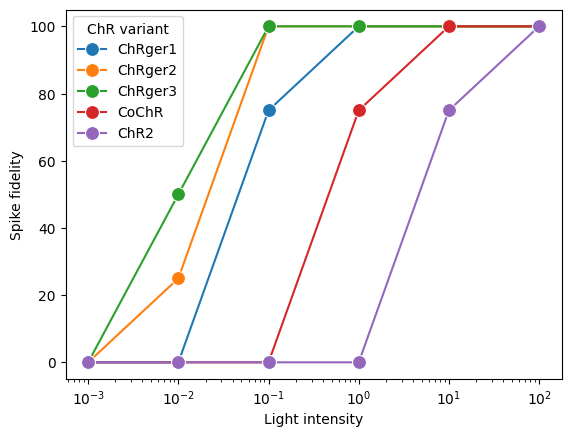

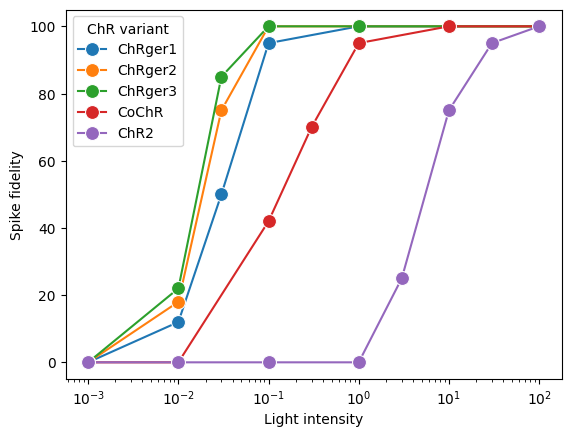

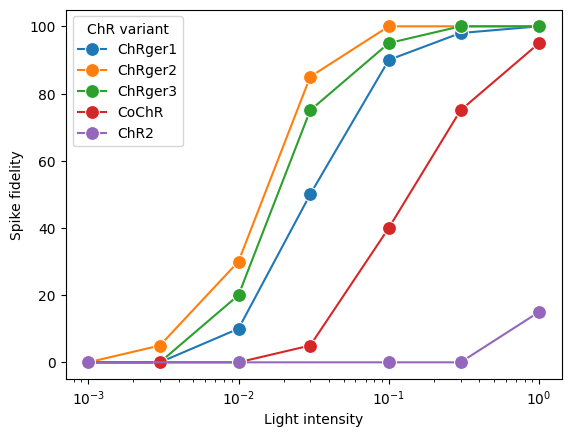

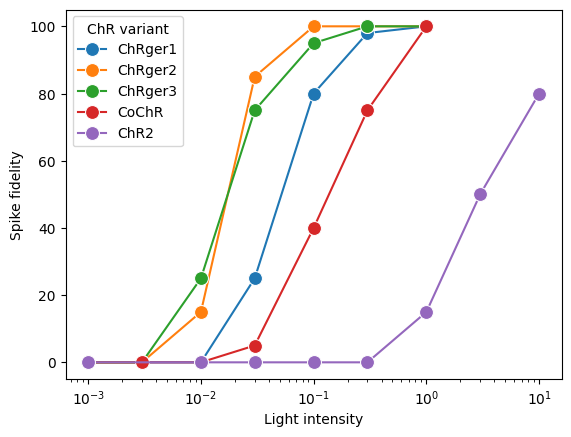

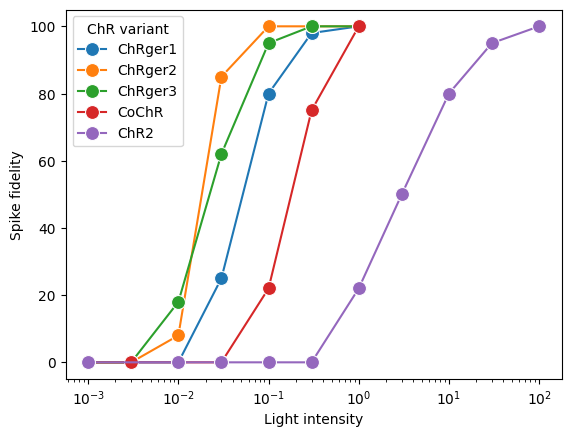

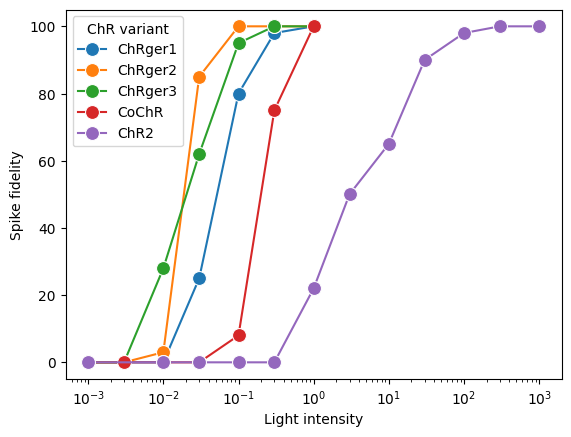

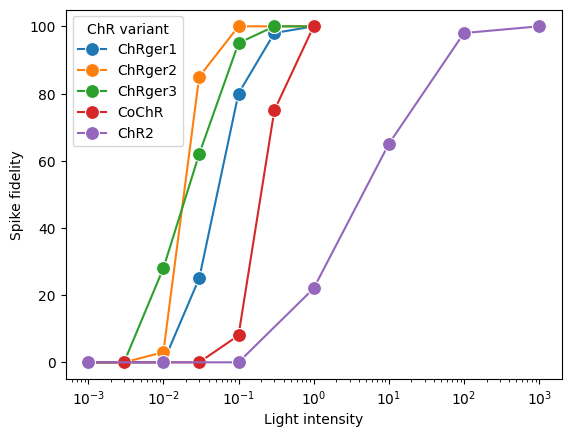

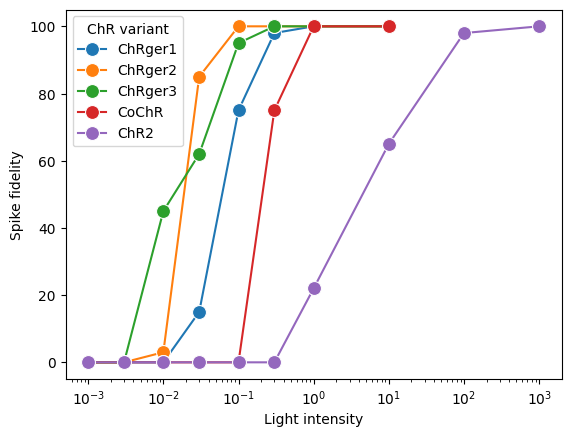

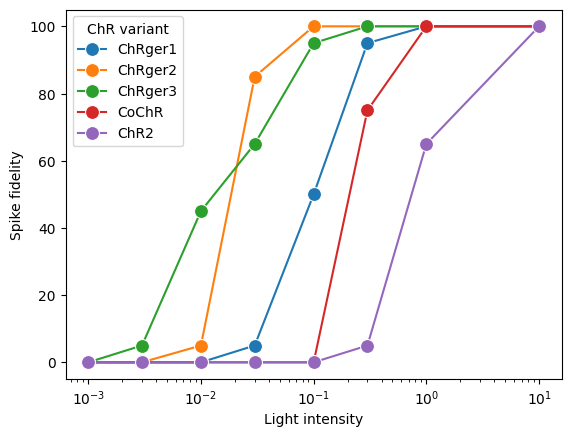

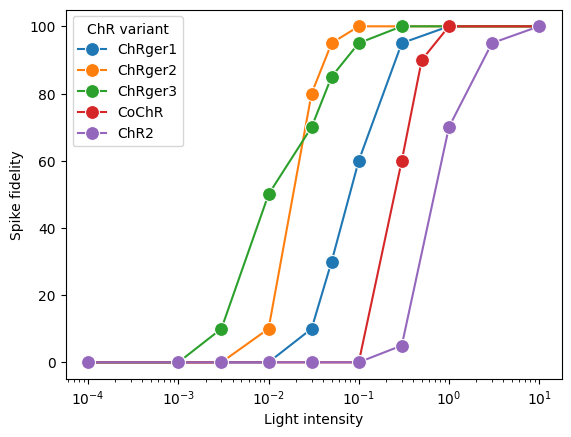

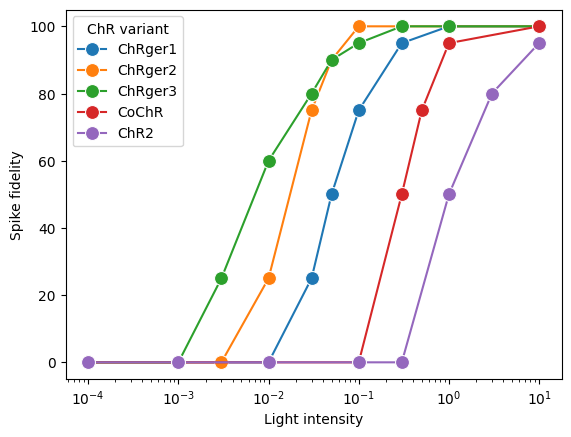

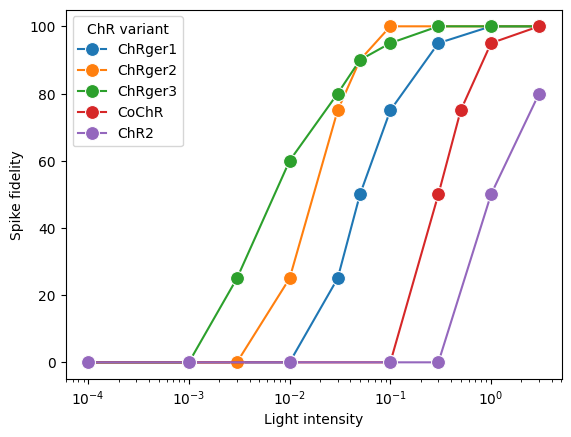

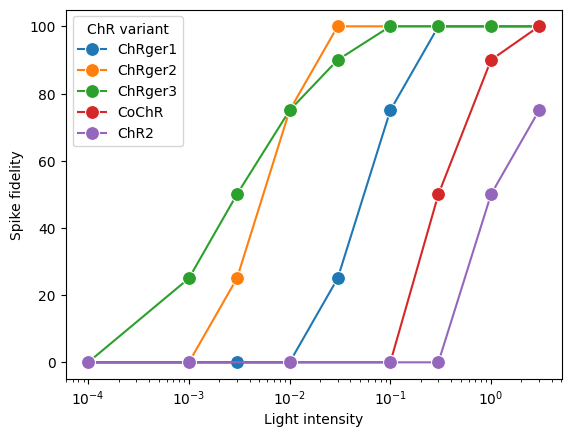

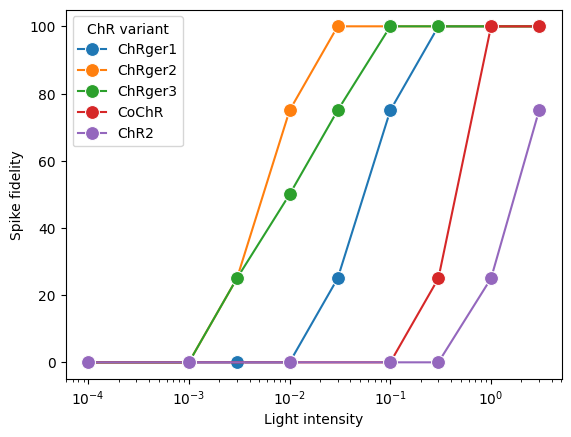

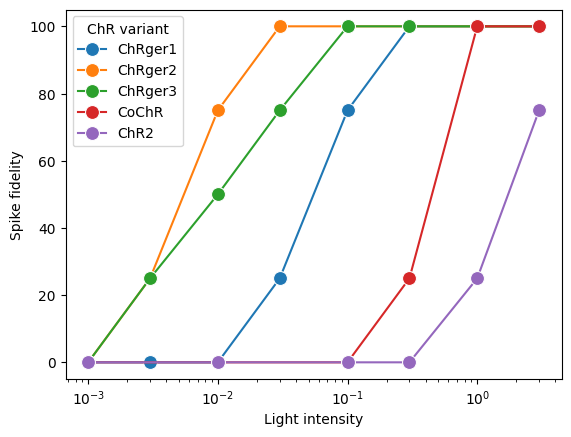

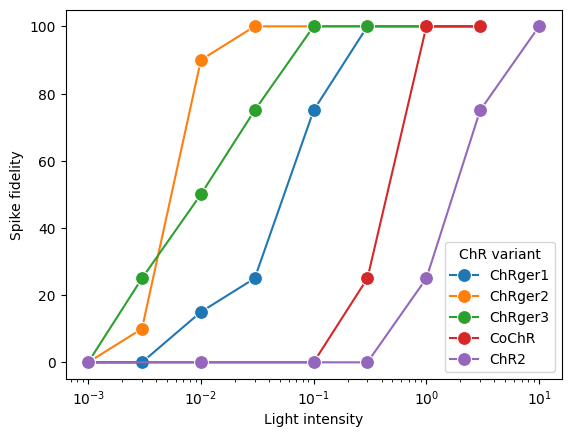

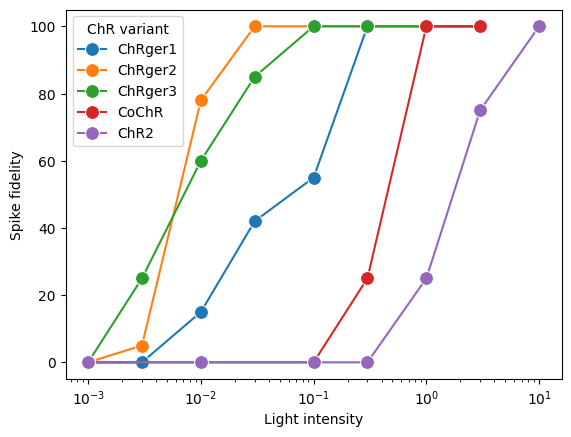

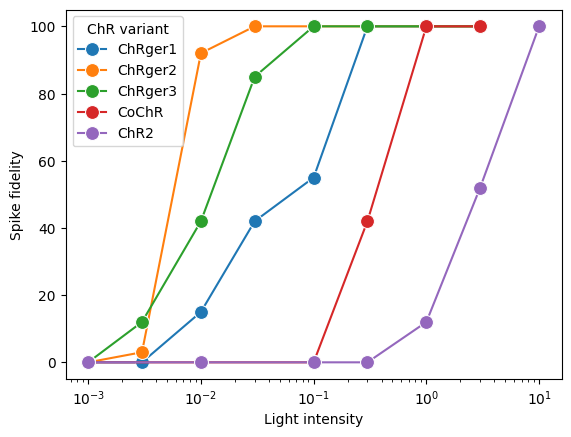

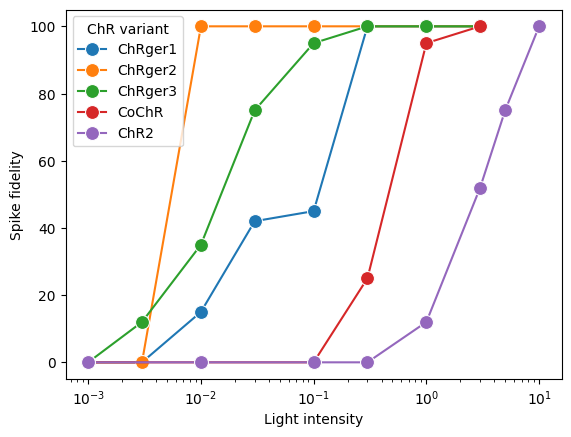

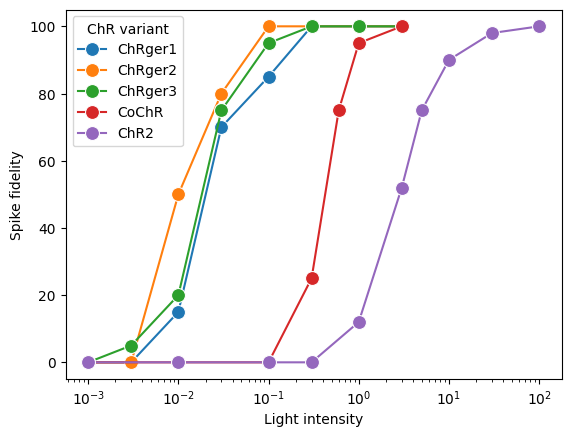

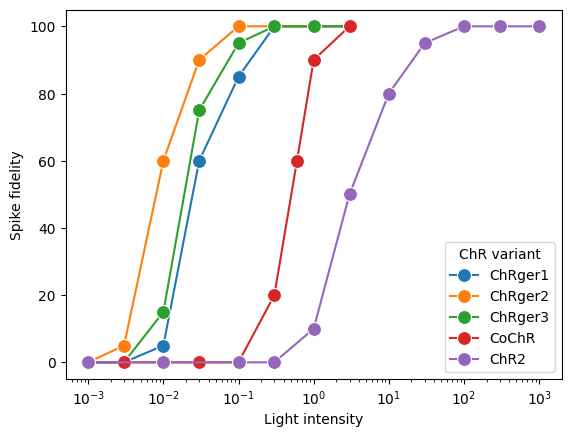

In [29]:
from matplotlib import pyplot as plt
from PIL import Image

fig, axes = plt.subplots()
sns.lineplot(
    data=panel_df,
    x='Light intensity',
    y='Spike fidelity',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    ax=axes
)
axes.semilogx()

# get plot as PIL Image
fig.savefig('plot_0.png')

generated_img_loop = Image.open('plot_0.png')
panel_df_loop = panel_df

for iter in range(20):




    claude_mm = BasicAnthropicLLM(model="claude-3-5-sonnet-20240620")


    prompt = f"""
We have extracted data from figure {fig_num}{panel.name}, plot {plot.name}. 
Given the full source figure and a recreation of the target plot from the extracted data, list five changes to make to the extracted data to improve the match.
You can refer to specific variable names, but do not reference colors!

Suggest changes according to the following priority:
1. changes that fix the relative ordering of quantities in the plot
1. changes to the range of the data (e.g. min and max values for a variable)
2. changes to the number of rows of data (e.g. missing values for independent variables)
3. changes that affect the values of many rows at a time

Extracted data used to generate recreated plot:
{panel_df_loop.to_markdown()}
    """


    response__loop = claude_mm.message(prompt, images = [source_image, generated_img_loop])

    feedback_loop = response__loop.content[0].text
    print(feedback_loop)

    output_parser = PydanticOutputParser(output_cls=DataFrameRowsOnly)


    columns = {iv.name: pd.Series() for iv in exp.independent_variables}
    dep_var = exp.dependent_variables[0]
    columns.update({dep_var.name: pd.Series()})
    df = pd.DataFrame(columns)

    prompt_base = """
We are extracting a dataframe containing the values of the data points in Figure {fig_num}{panel_name}, plot {plot_name}.
To validate that extraction, we have replotted the points and analyzed the differences. Can you help us use this analysis to improve the extracted dataframe?

Here is you the previous extracted data:
{df_table}

Here are changes based on comparing the extracted data to the source figure:
{feedback}

Please revise the dataframe by making these changes.
And remember, our goal is to match the data points in the plot EXACTLY - not just the shapes or trends.


Return your data using the following column schema: {schema}.
    """.format(
        fig_num = fig_num,
        panel_name = panel.name, 
        # dep_var_stat = dep_var.statistics[0],
        plot_name = plot.name,
        dep_var_name = dep_var.name,
        ind_vars = "\n".join([str(iv) for iv in ivs_with_values]),
        schema = ", ".join(df.columns),
        feedback = feedback_loop,
        df_table = panel_df_loop.to_markdown(),
    ).replace("{","<").replace("}",">")

    prompt = PromptTemplate(prompt_base, output_parser=output_parser).format(llm=plotreader._MM_LLM)

    data_response_loop = query_tool(prompt)
    panel_df_loop = output_parser.parse(data_response_loop.content).to_df(existing_df=df)

    # Create a new figure and axes
    fig, axes = plt.subplots()
    
    # Plot the line plot on the new axes
    sns.lineplot(
        data=panel_df_loop,
        x='Light intensity',
        y='Spike fidelity',
        hue='ChR variant',
        marker='o',
        # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
        markersize=10,
        ax=axes
    )
    axes.set_xscale('log')  # Set x-axis to logarithmic scale

    fig.savefig(f'plot_{iter+1}.png')
    generated_img_loop = Image.open(f'plot_{iter+1}.png')

In [401]:
print(prompt)


    YOUR OVERALL JOB:
        You were previously given the following task:

            In Figure 2d, plot Spike fidelity vs Light intensity, what are the values for the dependent variable Spike fidelity?
            And you were asked to return you data in a DataFrame and were provided with information about the independent variables and their values for this plot.

        Here is you the dataframe output from your previous response:
        |    |   Light intensity | ChR variant   |   Spike fidelity |
|---:|------------------:|:--------------|-----------------:|
|  0 |             0.001 | ChRger1       |                0 |
|  1 |             0.003 | ChRger1       |                0 |
|  2 |             0.01  | ChRger1       |               10 |
|  3 |             0.03  | ChRger1       |               40 |
|  4 |             0.06  | ChRger1       |               80 |
|  5 |             0.1   | ChRger1       |               95 |
|  6 |             0.3   | ChRger1       |            

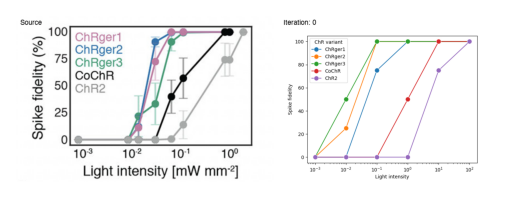

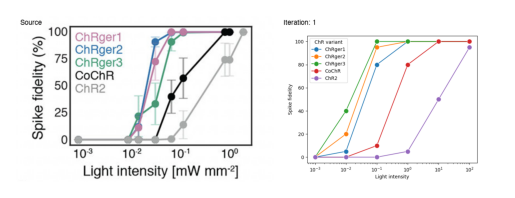

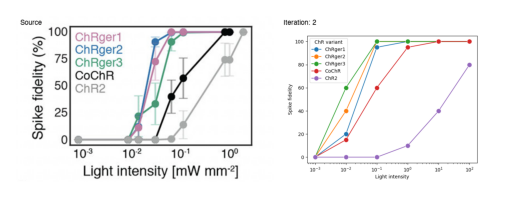

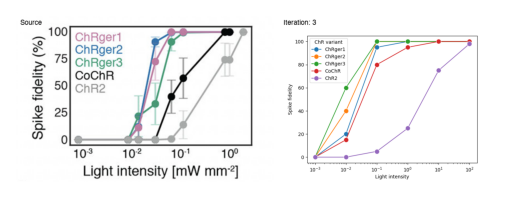

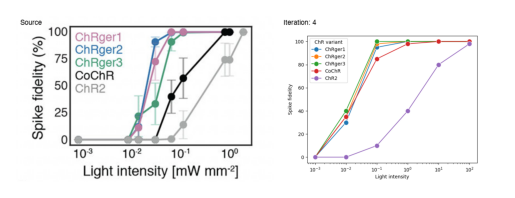

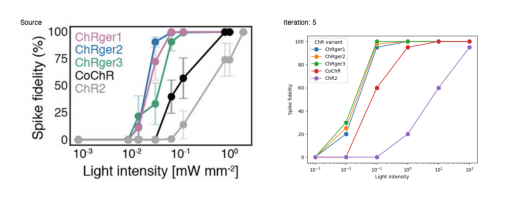

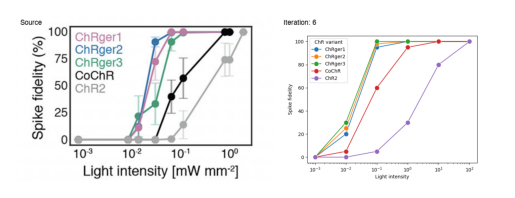

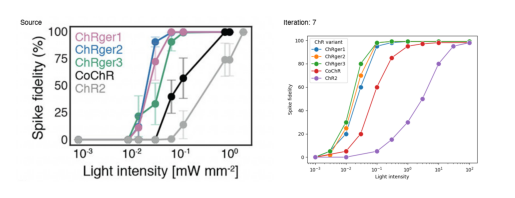

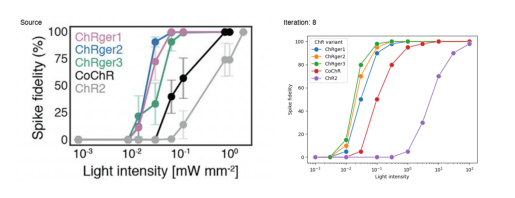

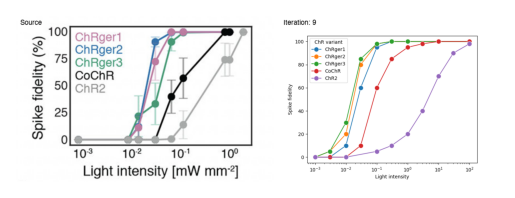

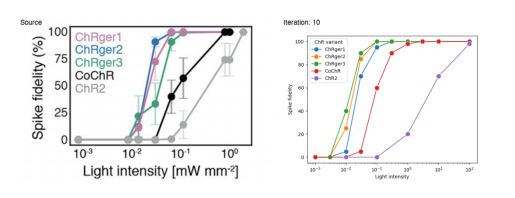

MP4 video saved as 'comparison.mp4'


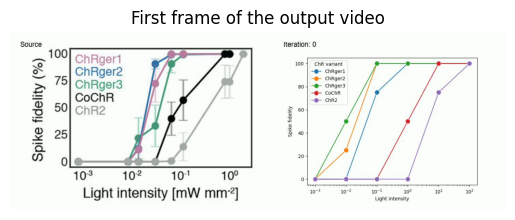

In [ ]:
source_panel = '/Users/loyalshababo/dev/plotreader/sandbox/figure3d_pic.png'
generated_fig_panel_path_base = "/Users/loyalshababo/dev/plotreader/sandbox/plot_{iter}.png"

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np

def create_side_by_side_image(source_img, generated_img, iter_number):
    # Resize both images to have the same height
    target_height = 480  # You can adjust this value as needed
    source_img_resized = source_img.resize((int(source_img.width * target_height / source_img.height), target_height))
    generated_img_resized = generated_img.resize((int(generated_img.width * target_height / generated_img.height), target_height))
    
    # Create a new image with the width of both resized images and the target height, plus padding
    padding = 20  # Adjust padding as needed
    total_width = source_img_resized.width + generated_img_resized.width + (3 * padding)  # Extra padding between images
    total_height = target_height + (2 * padding)
    combined_img = Image.new('RGB', (total_width, total_height), color='white')
    
    # Paste the resized source image on the left
    combined_img.paste(source_img_resized, (padding, padding))
    
    # Paste the resized generated image on the right
    combined_img.paste(generated_img_resized, (source_img_resized.width + (2 * padding), padding))
    
    # Add titles to the images
    draw = ImageDraw.Draw(combined_img)
    font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 20)
    
    # Add "Source" title
    draw.text((padding + 10, padding + 10), "Source", fill="black", font=font)
    
    # Add "Iteration: iter_number" title
    draw.text((source_img_resized.width + (2 * padding) + 10, padding + 10), f"Iteration: {iter_number}", fill="black", font=font)
    
    return combined_img

# Load the source panel image
source_img = Image.open(source_panel)

# Create a list to store the frames
frames = []

# Generate frames for each iteration
for iter in range(11):  # 0 to 10
    generated_img_path = generated_fig_panel_path_base.format(iter=iter)
    try:
        generated_img = Image.open(generated_img_path)
        
        # Create the side-by-side image with titles
        combined_img = create_side_by_side_image(source_img, generated_img, iter)
        
        # Convert PIL Image to numpy array
        frame = cv2.cvtColor(np.array(combined_img), cv2.COLOR_RGB2BGR)
        
        # Append the combined image to frames
        frames.append(frame)
    except FileNotFoundError:
        print(f"Warning: Image file not found for iteration {iter}")

# Check if we have any frames
if not frames:
    print("No frames were generated. Check if the image files exist.")
else:
    # Define the output video file
    output_file = 'comparison.mp4'

    # Get the frame size
    height, width, layers = frames[0].shape

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_file, fourcc, 1.0, (width, height))  # 2.0 fps for 5 seconds total with 10 frames

    # Write frames to video
    for frame in frames:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
        out.write(frame)

    # Release the VideoWriter
    out.release()

    print(f"MP4 video saved as '{output_file}'")

# Verify the output video
cap = cv2.VideoCapture(output_file)
if cap.isOpened():
    ret, frame = cap.read()
    if ret:
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("First frame of the output video")
        plt.show()
    else:
        print("Failed to read the first frame")
    cap.release()
else:
    print("Failed to open the output video file")


/var/folders/0w/7p0llwyd0n39my8_dt311mtr0000gn/T/ipykernel_39940/1437840151.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(axes.get_xticklabels(), rotation=90)


[]

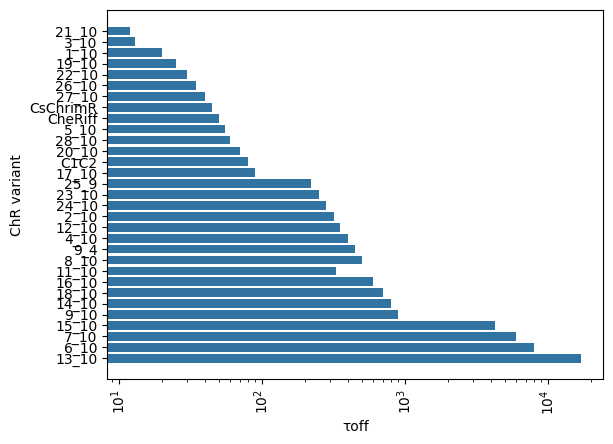

In [27]:
# panel_df_adjusted = panel_df.copy()
# panel_df_adjusted['τoff'] *= 1000

# horizontal bar plot
axes = sns.barplot(
    data=panel_df,
    x='τoff',
    y='ChR variant',
    orient='h',
)
# axes = sns.barplot(
#     data=panel_df,
#     x='ChR variant',
#     y='τoff',
# )
# rotate x-tick labels 90 deg
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.semilogx()



<Axes: xlabel='Wavelength', ylabel='Normalized photocurrent'>

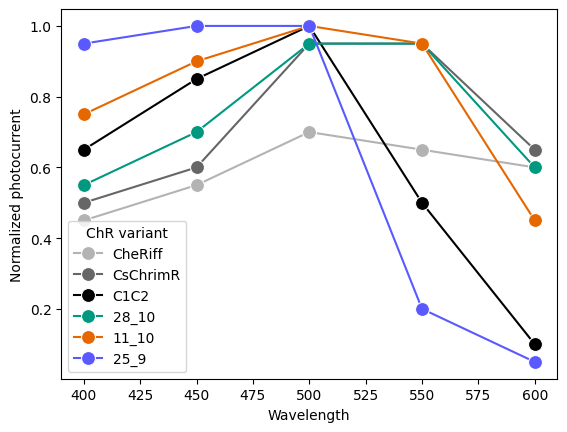

In [127]:


sns.lineplot(
    data=panel_df,
    x='Wavelength',
    y='Normalized photocurrent',
    hue='ChR variant',
    marker='o',
    # hue_order=['CheRiff', 'C1C2', "CsChrimR", "11_10", "28_10", "25_9"],
    markersize=10,
    palette=[[0.7, 0.7, 0.7], [0.4, 0.4, 0.4], [0, 0, 0], [0, .6 , .5], [0.9, 0.4, 0.0], [0.35, 0.35, 1.0]]
)
# plt.legend(title='ChR variant', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()

In [23]:
from plotreader.utils.structured_types.data import DataFrameRowsOnly
import pandas as pd

In [40]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import MetadataMode

In [42]:
for node in retrieverd_nodes[:-1]:
    try:
        display_source_node(node, source_length=100000)
    except:
        print(node)

**Node ID:** 7cf5ee59-0e97-445f-8884-f4e21f7bba21<br>**Similarity:** 0.40960259534169907<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents. (continued)<br>

**Node ID:** 5cb68f1f-e64c-4502-9da2-c42717a765e2<br>**Similarity:** 0.4057491962557034<br>**Text:** Figure 2. The model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.<br>

**Node ID:** d04f54e0-29ba-4046-92a6-7d2c6e9268f0<br>**Similarity:** 0.3793601396922902<br>**Text:** Figure 2 shows that the model-predicted ChRs exhibit a large range of functional properties often far exceeding the parents.

Section a shows representative current traces after 0.5 s light exposure for select designer ChR variants with corresponding expression and localization in HEK cells. Vertical scale bar for each ChR current trace represents 1 nA, and horizontal scale bar represents 250 ms. The variant color presented in (a) is constant throughout panels. CheRiff, C1C2 are represented in gray, CsChrimR in black, 11_10 in cyan, 12_10 in magenta, 25_9 in light blue, 10_10 in yellow, 15_10 in blue, 28_10 in orange, 21_10 in purple, and 3_10 in red. The bottom row shows fluorescence images of ChR expression in HEK cells, with a 20 μm scale bar.

Section b displays measured peak and steady-state photocurrent with different wavelengths of light in HEK cells (n=4-8 cells, see Dataset 2). Four wavelengths are shown: 397 nm, 481 nm, 546 nm, and 640 nm. The y-axis shows photocurrent in pA, with different scales for each wavelength. Peak currents are represented by dark gray bars, while steady-state currents are in light gray. Error bars are included.

Section c shows off-kinetics decay rate (τoff) following a 1 ms exposure to 481 nm light at 2.3 mW mm^2 (n=4-8 cells, see Dataset 2). Parent ChRs are highlighted in light gray. The x-axis shows τoff values on a logarithmic scale from 10^1 to 10^4 ms. Inset shows representative current traces with 1 ms light exposure for select ChRs revealing distinct profiles: ChR_21_10 (purple) turns off rapidly, ChR_3_10 (red) and ChR_25_9 (light blue) turn off more slowly, and ChR_15_10 (blue) exhibits little decrease in photocurrent 0.5 s after the light exposure. The time scale for these traces is 100 ms.

Section d shows normalized photocurrent as a function of wavelength for various ChR variants. The wavelengths range from 400 nm to 600 nm. Different colored lines represent different ChR variants, corresponding to the colors in panel a.

Section e displays peak photocurrent (left) and steady-state photocurrent (right) as a function of light intensity for various ChR variants. The x-axis shows light intensity from 10^-1 to 10^1 mW mm^-2 on a logarithmic scale. The y-axis shows photocurrent in pA, up to 2500 pA. Different colored lines represent different ChR variants, corresponding to the colors in panel a. Error bars are included.<br>**Image:**

**Node ID:** 22d9ee84-5d29-4f92-8527-e0ae97939355<br>**Similarity:** 0.36910398090655805<br>**Text:** Selection of designer ChRs using trained models<br>

**Node ID:** 5bbfd688-9a2b-439b-a86b-c786e9c193e7<br>**Similarity:** 0.35990217183769474<br>**Text:** Light delivery and imaging<br>

In [47]:
index_node = node.node

In [49]:
index_node.

'Light delivery and imaging'